In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy
from ydata_profiling import ProfileReport
import seaborn as sns
from typing import Any, Callable, Dict, Iterable
from numpy import ndarray
from sklearn.utils import resample
from utils import *
import joblib
import warnings
warnings.filterwarnings("ignore")
RANDOM=0
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

# Data preprocessing

In [70]:
df_users=pd.read_csv(r"data\train_users_2.csv")
df_sessions=pd.read_csv(r"data\sessions.csv")

## Clean up users dataset

In [71]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

1. Fix data types
2. Drop NDF from the label class
3. Clean up age outliers

In [72]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]
for categorical_feature in categorical_features:
    df_users[categorical_feature] = df_users[categorical_feature].astype('category')
df_users['date_account_created'] = pd.to_datetime(df_users['date_account_created'])
df_users['timestamp_first_active'] = pd.to_datetime(df_users['timestamp_first_active'], format='%Y%m%d%H%M%S').dt.date
df_users['date_first_booking'] = pd.to_datetime(df_users['date_first_booking'])
df_users=df_users[df_users['country_destination'] != 'NDF']
df_users.loc[df_users.age > 100, 'age'] = np.nan
df_users.loc[df_users.age < 18, 'age'] = np.nan

### Extract date info into different features

Drop the year feautres as they are low variant from 2010 to 2014.

In [73]:
# df_users['date_account_created_year'] = pd.DatetimeIndex(df_users['date_account_created']).year
df_users['date_account_created_month'] = pd.DatetimeIndex(df_users['date_account_created']).month
df_users['date_account_created_day'] = pd.DatetimeIndex(df_users['date_account_created']).weekday
# df_users['date_first_booking_year'] = pd.DatetimeIndex(df_users['date_first_booking']).year
df_users['date_first_booking_month'] = pd.DatetimeIndex(df_users['date_first_booking']).month
df_users['date_first_booking_day'] = pd.DatetimeIndex(df_users['date_first_booking']).weekday
# df_users['timestamp_first_active_year'] = pd.DatetimeIndex(df_users['timestamp_first_active']).year
df_users['timestamp_first_active_month'] = pd.DatetimeIndex(df_users['timestamp_first_active']).month
df_users['timestamp_first_active_day'] = pd.DatetimeIndex(df_users['timestamp_first_active']).weekday
df_users.drop(['date_account_created','date_first_booking','timestamp_first_active'],axis=1,inplace = True)

## Clean sessions data

In [74]:
df_sessions.dropna(subset='user_id',inplace=True)

Fill missing values with the most frequent class.

In [75]:
cols=['action', 'action_type', 'action_detail', 'device_type']
for col in cols:
    df_sessions[col].fillna(df_sessions[col].mode()[0], inplace=True)
df_sessions['secs_elapsed'].fillna(0, inplace=True)

### Group by user id to get one record per user

In [76]:
df_sessions = df_sessions.groupby("user_id", as_index= False).agg(lambda x:x.tolist())
df_sessions['device_type']=df_sessions['device_type'].apply(lambda x: list(set(x)))
cols=['action', 'action_type', 'action_detail', 'device_type']
for col in cols:
    df_sessions[col] = df_sessions[col].apply(lambda x: ','.join(x))
df_sessions.head()    

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,00023iyk9l,"index,dashboard,header_userpic,dashboard,callb...","view,view,data,view,partner_callback,message_p...","view_search_results,dashboard,header_userpic,d...","Mac Desktop,iPhone","[20438.0, 787.0, 850.0, 934.0, 0.0, 129817.0, ..."
1,0010k6l0om,"search_results,show,personalize,show,search_re...","click,view,data,view,click,click,view,data,vie...","view_search_results,p3,wishlist_content_update...",Mac Desktop,"[1708.0, 21260.0, 1223.0, 26.0, 847.0, 1230.0,..."
2,001wyh0pz8,"search,search,search,show,social_connections,i...","click,click,click,view,data,-unknown-,view,-un...","view_search_results,view_search_results,view_s...",Android App Unknown Phone/Tablet,"[622.0, 1813.0, 1507.0, 6327.0, 927.0, 142.0, ..."
3,0028jgx1x1,"show,reviews,show,search,show,search,reviews,c...","view,data,view,click,view,click,data,submit,-u...","user_profile,listing_reviews,p3,view_search_re...","-unknown-,Android Phone","[6162.0, 75.0, 86.0, 13710.0, 25217.0, 10989.0..."
4,002qnbzfs5,"social_connections,payment_methods,create,show...","data,-unknown-,-unknown-,view,data,data,data,v...","user_social_connections,-unknown-,-unknown-,us...","-unknown-,iPhone","[17135.0, 711.0, 274.0, 179.0, 483.0, 1.0, 782..."


Use mean value for the secs_elapsed feature for each user.

In [77]:
df_sessions['secs_elapsed']=df_sessions['secs_elapsed'].apply(lambda x: np.mean(x))
df_sessions.head() 

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,00023iyk9l,"index,dashboard,header_userpic,dashboard,callb...","view,view,data,view,partner_callback,message_p...","view_search_results,dashboard,header_userpic,d...","Mac Desktop,iPhone",21697.400000
1,0010k6l0om,"search_results,show,personalize,show,search_re...","click,view,data,view,click,click,view,data,vie...","view_search_results,p3,wishlist_content_update...",Mac Desktop,9310.206349
2,001wyh0pz8,"search,search,search,show,social_connections,i...","click,click,click,view,data,-unknown-,view,-un...","view_search_results,view_search_results,view_s...",Android App Unknown Phone/Tablet,3144.055556
3,0028jgx1x1,"show,reviews,show,search,show,search,reviews,c...","view,data,view,click,view,click,data,submit,-u...","user_profile,listing_reviews,p3,view_search_re...","-unknown-,Android Phone",9580.967742
4,002qnbzfs5,"social_connections,payment_methods,create,show...","data,-unknown-,-unknown-,view,data,data,data,v...","user_social_connections,-unknown-,-unknown-,us...","-unknown-,iPhone",8221.901141


## Merging two datasets

In [78]:
df_merge = df_users.merge(df_sessions, left_on='id', right_on='user_id', how='inner')
df_merge.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,date_first_booking_month,date_first_booking_day,timestamp_first_active_month,timestamp_first_active_day,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,...,1,5,1,2,d1mm9tcy42,"lookup,search_results,lookup,search_results,lo...","view,click,view,click,view,click,view,data,vie...","view_search_results,view_search_results,view_s...","-unknown-,Windows Desktop",26988.417323
1,4rvqpxoh3h,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,...,1,3,1,2,4rvqpxoh3h,"campaigns,active,create,notifications,listings...","-unknown-,-unknown-,-unknown-,-unknown-,-unkno...","-unknown-,-unknown-,-unknown-,-unknown-,-unkno...",iPhone,319.375000
2,xwxei6hdk4,FEMALE,32.0,facebook,0,en,seo,google,linked,Web,...,1,1,1,2,xwxei6hdk4,"dashboard,header_userpic,show,ask_question,ask...","view,data,message_post,submit,submit,message_p...","dashboard,header_userpic,message_post,contact_...","iPad Tablet,iPhone",7096.142857
3,ro2stddszp,-unknown-,19.0,basic,0,en,sem-brand,google,untracked,Web,...,12,3,1,2,ro2stddszp,"similar_listings,lookup,personalize,index,pers...","data,view,data,view,data,view,view,data,view,c...","similar_listings,view_search_results,wishlist_...",Mac Desktop,29869.790698
4,awiurksqr3,FEMALE,32.0,facebook,0,en,direct,direct,untracked,Web,...,1,3,1,2,awiurksqr3,"ask_question,show,dashboard,login,authenticate...","submit,message_post,view,view,submit,data,-unk...","contact_host,message_post,dashboard,login_page...","iPad Tablet,iPhone",45900.875000


## Get label dataset

In [79]:
labels=df_merge['country_destination'].values
labels[:10]

array(['other', 'GB', 'US', 'other', 'US', 'other', 'FR', 'US', 'FR',
       'US'], dtype=object)

In [80]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28774 entries, 0 to 28773
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   id                            28774 non-null  object  
 1   gender                        28774 non-null  category
 2   age                           22279 non-null  float64 
 3   signup_method                 28774 non-null  category
 4   signup_flow                   28774 non-null  category
 5   language                      28774 non-null  category
 6   affiliate_channel             28774 non-null  category
 7   affiliate_provider            28774 non-null  category
 8   first_affiliate_tracked       28769 non-null  category
 9   signup_app                    28774 non-null  category
 10  first_device_type             28774 non-null  category
 11  first_browser                 28774 non-null  category
 12  country_destination           28774 non-null  

## Get feature dataset

In [81]:
vec=['gender','signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser','device_type']
num=['age','date_account_created_year',
       'date_account_created_month', 'date_account_created_day',
       'date_first_booking_year', 'date_first_booking_month',
       'date_first_booking_day', 'timestamp_first_active_year',
       'timestamp_first_active_month', 'timestamp_first_active_day','secs_elapsed']
tfidf=['action', 'action_type', 'action_detail']
to_drop=['id','country_destination','user_id']

In [82]:
data=df_merge.drop(to_drop,axis=1)
data

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,...,date_account_created_day,date_first_booking_month,date_first_booking_day,timestamp_first_active_month,timestamp_first_active_day,action,action_type,action_detail,device_type,secs_elapsed
0,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,...,2,1,5,1,2,"lookup,search_results,lookup,search_results,lo...","view,click,view,click,view,click,view,data,vie...","view_search_results,view_search_results,view_s...","-unknown-,Windows Desktop",26988.417323
1,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,...,2,1,3,1,2,"campaigns,active,create,notifications,listings...","-unknown-,-unknown-,-unknown-,-unknown-,-unkno...","-unknown-,-unknown-,-unknown-,-unknown-,-unkno...",iPhone,319.375000
2,FEMALE,32.0,facebook,0,en,seo,google,linked,Web,iPad,...,2,1,1,1,2,"dashboard,header_userpic,show,ask_question,ask...","view,data,message_post,submit,submit,message_p...","dashboard,header_userpic,message_post,contact_...","iPad Tablet,iPhone",7096.142857
3,-unknown-,19.0,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,...,2,12,3,1,2,"similar_listings,lookup,personalize,index,pers...","data,view,data,view,data,view,view,data,view,c...","similar_listings,view_search_results,wishlist_...",Mac Desktop,29869.790698
4,FEMALE,32.0,facebook,0,en,direct,direct,untracked,Web,iPad,...,2,1,3,1,2,"ask_question,show,dashboard,login,authenticate...","submit,message_post,view,view,submit,data,-unk...","contact_host,message_post,dashboard,login_page...","iPad Tablet,iPhone",45900.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28769,-unknown-,55.0,basic,0,en,sem-brand,google,omg,Web,Android Tablet,...,0,6,0,6,0,"pending,show,requested,requested,edit,edit,not...","booking_request,message_post,view,view,view,vi...","pending,message_post,p5,p5,edit_profile,edit_p...","iPhone,Tablet",25942.138889
28770,MALE,43.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,...,0,3,0,6,0,"create,header_userpic,cancellation_policy_clic...","submit,data,click,view,view,view","create_user,header_userpic,cancellation_policy...",Windows Desktop,28326.500000
28771,FEMALE,34.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,...,0,8,2,6,0,"search_results,index,personalize,index,dashboa...","click,view,data,view,view,data,view,click,view...","view_search_results,view_search_results,wishli...","-unknown-,Mac Desktop",16440.062500
28772,FEMALE,36.0,basic,0,en,sem-brand,google,linked,Web,Mac Desktop,...,0,7,6,6,0,"show,show,similar_listings_v2,show,personalize...","view,view,view,view,data,view,view,submit,view...","view_search_results,p3,view_search_results,vie...",Mac Desktop,38374.601504


In [83]:
data.shape

(28774, 22)

In [84]:
labels.shape

(28774,)

# Train and test dataset split

In [85]:
from sklearn.base import BaseEstimator
from sklearn.compose import make_column_transformer
from sklearn.ensemble import (
    GradientBoostingClassifier, RandomForestClassifier, VotingClassifier)
from sklearn.exceptions import NotFittedError
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, f1_score
from sklearn.model_selection import (
    BaseCrossValidator, GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.utils.fixes import loguniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Reserve 15% data for testing.

In [86]:
#split dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    data,
    labels,
    random_state=RANDOM,
    test_size=0.15,
    stratify=labels)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28774 entries, 0 to 28773
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   gender                        28774 non-null  category
 1   age                           22279 non-null  float64 
 2   signup_method                 28774 non-null  category
 3   signup_flow                   28774 non-null  category
 4   language                      28774 non-null  category
 5   affiliate_channel             28774 non-null  category
 6   affiliate_provider            28774 non-null  category
 7   first_affiliate_tracked       28769 non-null  category
 8   signup_app                    28774 non-null  category
 9   first_device_type             28774 non-null  category
 10  first_browser                 28774 non-null  category
 11  date_account_created_month    28774 non-null  int64   
 12  date_account_created_day      28774 non-null  

Some missing values to be filled by imputers in the pipeline.

In [88]:
data.isnull().sum()*100/data.shape[0]

gender                           0.000000
age                             22.572461
signup_method                    0.000000
signup_flow                      0.000000
language                         0.000000
affiliate_channel                0.000000
affiliate_provider               0.000000
first_affiliate_tracked          0.017377
signup_app                       0.000000
first_device_type                0.000000
first_browser                    0.000000
date_account_created_month       0.000000
date_account_created_day         0.000000
date_first_booking_month         0.000000
date_first_booking_day           0.000000
timestamp_first_active_month     0.000000
timestamp_first_active_day       0.000000
action                           0.000000
action_type                      0.000000
action_detail                    0.000000
device_type                      0.000000
secs_elapsed                     0.000000
dtype: float64

In [89]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(24457, 22) (4317, 22) (24457,) (4317,)


# Feature engineering

In [90]:
# missing data imputers
med_imputer=SimpleImputer(strategy='median')
mod_imputer=SimpleImputer(strategy='most_frequent')

In [91]:
# 'age', 'first_affiliate_tracked', 'device_type' manual transfermation
ohe=['gender','signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 
       'signup_app', 'first_device_type', 'first_browser']
# num=['date_account_created_year',
#        'date_account_created_month', 'date_account_created_day',
#        'date_first_booking_year', 'date_first_booking_month',
#        'date_first_booking_day', 'timestamp_first_active_year',
#        'timestamp_first_active_month', 'timestamp_first_active_day','secs_elapsed']
num=[
       'date_account_created_month', 'date_account_created_day',
        'date_first_booking_month',
       'date_first_booking_day', 
       'timestamp_first_active_month', 'timestamp_first_active_day','secs_elapsed']
tfidf=['action', 'action_type', 'action_detail']

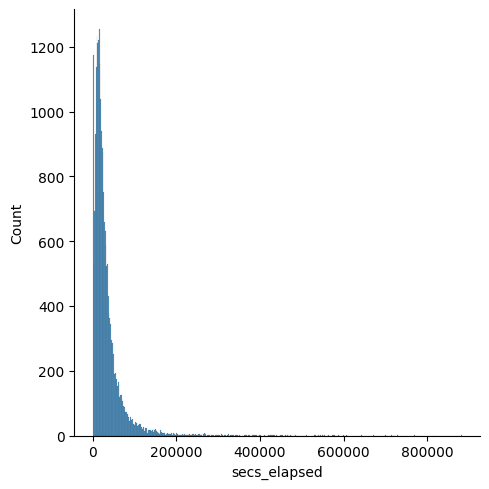

In [92]:
sns.displot(x_train['secs_elapsed'])

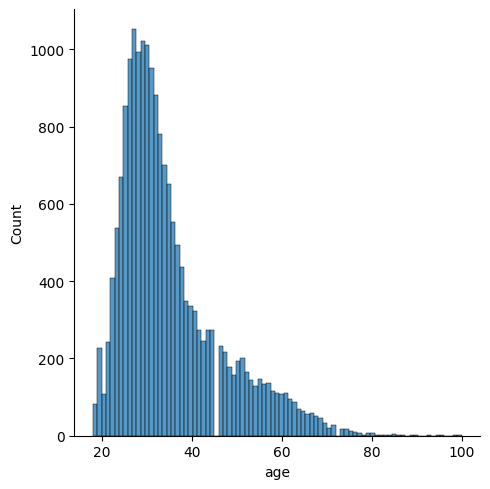

In [93]:
sns.displot(x_train['age'])

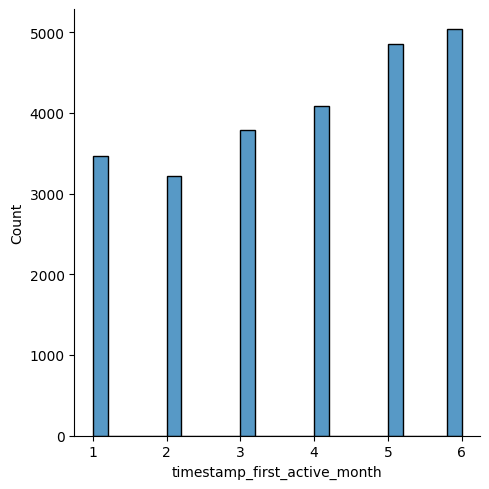

In [94]:
sns.displot(x_train['timestamp_first_active_month'])

## Form column feature transformer  

1. Doing (1,4) tfid vectorization on three session columns to capture the series information.
2. Use one hot coding for categorical classes, e.g. first_affiliate_tracked, gender, signup_metod etc.
3. Use Count vecterization for device_type as the same device can be used multiple times.
4. Do normalization on numerical features,e.g. month, day, secs_elapsed etc.

In [95]:
transformers=[]
for i in tfidf:
    vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=100)
    vectorizer.fit_transform(x_train[i])
    vocab=list(set((vectorizer.get_feature_names_out()).tolist()))
    item=('tfidf_'+str(i),TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=100,vocabulary=vocab), i)
    transformers.append(item)
# transformers

In [96]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# transformers = [('tfidf_'+str(col),TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=100,vocabulary=vocab), col) for col in tfidf]
feature_pipeline= ColumnTransformer([
    ('',make_pipeline(med_imputer, MinMaxScaler()), ['age']),
    ('_',make_pipeline(mod_imputer, OneHotEncoder(handle_unknown='ignore')), ['first_affiliate_tracked']),
    ('device_type',CountVectorizer(),'device_type'),
    ('num',MinMaxScaler(), num),
    ('ohe',OneHotEncoder(handle_unknown='ignore'),ohe)
    ,*transformers
    ])

feature_pipeline.fit(x_train)

ColumnTransformer(transformers=[('',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age']),
                                ('_',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['first_affiliate_tracked']),
                                ('device_type', CountVectorizer(),
                                 'dev...
                                                             'change_trip_characteristics',
                                                             'change_trip_characteristics '
                                                             'view_search_results '
                                                             'wishlist_content_update '
                                                             'p3',
                                                             'change_trip_characteristics '
                                                             'similar_listings '
                                                             'view_search_results',
                                                             'header_userpic',
                                                             'p3 user_profile',
                                                             'p3 '
                                                             'change_trip_characteristics',
                                                             'view_search_results '
                                                             'p3 '
                                                             'view_search_results',
                                                             'message_thread '
                                                             'message_thread '
                                                             'message_thread',
                                                             'p3 p3', ...]),
                                 'action_detail')])

## Final features extracted

In [97]:
feature_names = feature_pipeline.get_feature_names_out()
feature_names.tolist()

['__age',
 '___first_affiliate_tracked_linked',
 '___first_affiliate_tracked_local ops',
 '___first_affiliate_tracked_marketing',
 '___first_affiliate_tracked_omg',
 '___first_affiliate_tracked_product',
 '___first_affiliate_tracked_tracked-other',
 '___first_affiliate_tracked_untracked',
 'device_type__android',
 'device_type__app',
 'device_type__blackberry',
 'device_type__chromebook',
 'device_type__desktop',
 'device_type__ipad',
 'device_type__iphone',
 'device_type__ipodtouch',
 'device_type__linux',
 'device_type__mac',
 'device_type__opera',
 'device_type__phone',
 'device_type__tablet',
 'device_type__unknown',
 'device_type__windows',
 'num__date_account_created_month',
 'num__date_account_created_day',
 'num__date_first_booking_month',
 'num__date_first_booking_day',
 'num__timestamp_first_active_month',
 'num__timestamp_first_active_day',
 'num__secs_elapsed',
 'ohe__gender_-unknown-',
 'ohe__gender_FEMALE',
 'ohe__gender_MALE',
 'ohe__gender_OTHER',
 'ohe__signup_method_b

In [98]:
len(feature_names)

431

### Transfor features into vectors

In [99]:
X_train = feature_pipeline.transform(x_train)
X_test = feature_pipeline.transform(x_test)

### Label encoded

In [100]:
le = LabelEncoder()
Y_train = le.fit_transform(y_train)
Y_test = le.transform(y_test)

In [101]:
label_dict={}
for i, category in enumerate(le.classes_):
    label_dict[i]=category
label_dict

{0: 'AU',
 1: 'CA',
 2: 'DE',
 3: 'ES',
 4: 'FR',
 5: 'GB',
 6: 'IT',
 7: 'NL',
 8: 'PT',
 9: 'US',
 10: 'other'}

In [102]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(24457, 431) (4317, 431) (24457,) (4317,)


In [103]:
np.any(X_train.toarray())<0

False

# Model development

## Metrics for training and evaluation

Two metrics are selected for evalutation.
1. ROC AUC (Area under the ROC Curve): a common peformance metric to evaluate the accuracy of a classifier.
2. NDCG(Normalized discounted cumulative gain)@K=5: a ranking metric to measure ranking quality.

NDCG is also used for model training as the it is more intuitive measure.The utimate goal to predict the first booking destination by the user is for company to better provide relative information for the user and enable the targeting advertisement. It is always good to know the top K options to prioritize the service. The correct prediction on the most possible destination is important but a good ranking of avaliable options is more relevant metric.

Definition of NDCG
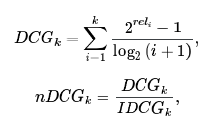
where \\(rel_i\\) is the relevance of the result at position \\(i\\).

\\(IDCG_k\\) is the maximum possible (ideal) \\(DCG\\) for a given set of queries. All NDCG calculations are relative values on the interval 0.0 to 1.0.

For each new user, a maximum of 5 predictions are made on the country of the first booking. The ground truth country is marked with relevance = 1, while the rest have relevance = 0.

In [104]:
# NDCG Scorer function
import numpy as np
from sklearn.preprocessing import LabelBinarizer

def dcg_score(y_true, y_score, k=5):
    
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(y_true, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(predictions.shape[1] + 1))
    T = lb.transform(y_true)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)
roc_auc_ovr_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr',average= 'weighted')
# f1_weighted_scorer = make_scorer(f1_score, average= 'weighted')

## Build the optimization search experiment class

### Use 5-fold cross validation for model experiments

In [105]:
cross_validator = StratifiedKFold(n_splits=5)

### Randomized search is used for hyperparamer tuning

In [106]:
metrics = {'ndcg': ndcg_scorer,
            'auc': roc_auc_ovr_scorer
          }

MetricScorer = Callable[[BaseEstimator, Iterable[int], Iterable[int]], float]

class MLExperimentRunner:
    """Model training and metric calculation automation."""
    
    def __init__(self,
                 metrics: Dict[str, MetricScorer],
                 cross_validator: BaseCrossValidator,
                 model_selection_metric: str,
                 X_train: ndarray,
                 y_train: ndarray,
                 X_test: ndarray,
                 y_test: ndarray,) -> None:
        
        self.metrics = metrics
        self.cv = cross_validator
        self.selection_metric = model_selection_metric
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        return None
    
    def run(self, estimator: BaseEstimator,
            param_grid: Dict[str, Any], n_results: int = 10) -> BaseEstimator:
        """Run an experiment."""
        
        scorers = {name: metric
                   for name, metric in self.metrics.items()}
        
        experiment = RandomizedSearchCV(
            estimator, param_grid, scoring=scorers, cv=self.cv,
            n_iter=n_results,random_state=0,
            refit=self.selection_metric, n_jobs=-1)
        
        experiment.fit(self.X_train, self.y_train)
        
        self._display_results(experiment.cv_results_, n_results)
        self._display_test_metrics(experiment.best_estimator_)
        
        return experiment.best_estimator_
    
    def _display_test_metrics(self, estimator: BaseEstimator) -> None:
        """Print metrics for test data to stdout."""
        
#         predictions = estimator.predict(self.X_test)
        results = {
            metric_name: metric_func(estimator,self.X_test, self.y_test)
            for metric_name, metric_func in self.metrics.items()}
        
        print('----------------------------------------')
        print('-- TEST DATA METRICS (best estimator) --')
        print('---------------------------------------')
        for metric_name, metric_value in results.items():
            print(f'{metric_name}: {metric_value:.4f}')
        print('----------------------------------------')
        
        return None

    def _display_results(self, cv_results: Dict[str, Any],
                         n_results: int) -> None:
        """Display cross validation results as DataFrame."""
        
        cv_data = pd.DataFrame(cv_results)

        metric_col_names = [
            e 
            for name in self.metrics.keys()
            for e in [f'mean_test_{name}', f'std_test_{name}']]

        selection_metric_col_name = f'mean_test_{self.selection_metric}'

        cv_data.sort_values(
            by=selection_metric_col_name, ascending=False, inplace=True)
        cv_data.reset_index(inplace=True)

        display(cv_data[['params'] + metric_col_names].head(n_results))

        return None

In [107]:
ml_experiment = MLExperimentRunner(
    metrics, cross_validator, 'ndcg', X_train, Y_train, X_test, Y_test)

## Model training

### 10 experiments per model using different combinations of parameters

### Random forest with class balancing

In [45]:
rf_model = ml_experiment.run(
    RandomForestClassifier(class_weight='balanced', random_state=0),
    {'n_estimators': [50, 100, 200, 1000],
     'max_depth': [5, 10, 20]})

,params,mean_test_ndcg,std_test_ndcg,mean_test_auc,std_test_auc
0,"{'n_estimators': 1000, 'max_depth': 20}",0.825687,0.000352,0.511170,0.007178
1,"{'n_estimators': 200, 'max_depth': 20}",0.823851,0.000664,0.508944,0.008847
2,"{'n_estimators': 100, 'max_depth': 20}",0.820628,0.000883,0.506197,0.008005
3,"{'n_estimators': 50, 'max_depth': 20}",0.813570,0.002043,0.501900,0.007478
4,"{'n_estimators': 1000, 'max_depth': 10}",0.769587,0.008103,0.538657,0.004949
5,"{'n_estimators': 200, 'max_depth': 10}",0.737012,0.006500,0.535275,0.008550
6,"{'n_estimators': 50, 'max_depth': 10}",0.656322,0.002475,0.523345,0.007877
7,"{'n_estimators': 1000, 'max_depth': 5}",0.474477,0.022774,0.557962,0.003927
8,"{'n_estimators': 200, 'max_depth': 5}",0.456217,0.020348,0.557076,0.004226
9,"{'n_estimators': 100, 'max_depth': 5}",0.432840,0.010824,0.552434,0.005978


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
ndcg: 0.8270
auc: 0.5245
----------------------------------------


### Gradient boosting

In [40]:
from xgboost import XGBClassifier     
xgb_model = ml_experiment.run(
    XGBClassifier(),
    {'n_estimators': np.random.randint(10,200,10),
     'max_depth': [1, 2]})

,params,mean_test_ndcg,std_test_ndcg,mean_test_auc,std_test_auc
0,"{'n_estimators': 45, 'max_depth': 1}",0.828248,0.000275,0.596854,0.006897
1,"{'n_estimators': 46, 'max_depth': 1}",0.828082,0.000289,0.597092,0.006905
2,"{'n_estimators': 94, 'max_depth': 1}",0.827940,0.000321,0.599217,0.005899
3,"{'n_estimators': 11, 'max_depth': 1}",0.827838,0.000776,0.583291,0.006292
4,"{'n_estimators': 175, 'max_depth': 1}",0.827793,0.000858,0.598079,0.004517
5,"{'n_estimators': 11, 'max_depth': 2}",0.827478,0.000481,0.590035,0.008015
6,"{'n_estimators': 121, 'max_depth': 2}",0.826148,0.000432,0.595111,0.004253
7,"{'n_estimators': 130, 'max_depth': 2}",0.826005,0.000560,0.595003,0.003990
8,"{'n_estimators': 147, 'max_depth': 2}",0.825878,0.000479,0.594067,0.005360
9,"{'n_estimators': 168, 'max_depth': 2}",0.825451,0.000759,0.592545,0.005460


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
ndcg: 0.8283
auc: 0.6152
----------------------------------------


### MLP

In [43]:
mlp_model = ml_experiment.run(
    MLPClassifier(random_state=0,learning_rate='adaptive',early_stopping = True, max_iter = 200),
    {'alpha': loguniform(1e-5, 1e-3),
     'hidden_layer_sizes': [(100,),(16,8,),(8,4,2,)],
     'learning_rate_init': loguniform(1e-4, 1e-2)})

,params,mean_test_ndcg,std_test_ndcg,mean_test_auc,std_test_auc
0,"{'alpha': 1.724046009924229e-05, 'hidden_layer...",0.827871,0.000393,0.571989,0.008411
1,"{'alpha': 0.00011423254155608371, 'hidden_laye...",0.827640,0.000620,0.539378,0.006347
2,"{'alpha': 0.0001252065381499946, 'hidden_layer...",0.827053,0.000670,0.567447,0.009908
3,"{'alpha': 3.5100442309980525e-05, 'hidden_laye...",0.826836,0.000709,0.561615,0.008800
4,"{'alpha': 0.00039978040531536154, 'hidden_laye...",0.826754,0.000665,0.560643,0.008227
5,"{'alpha': 1.0975815419380158e-05, 'hidden_laye...",0.826658,0.000779,0.560181,0.008413
6,"{'alpha': 0.0005198657849887132, 'hidden_layer...",0.824764,0.001286,0.524947,0.008185
7,"{'alpha': 0.0005495716186411615, 'hidden_layer...",0.772409,0.000079,0.501799,0.004991
8,"{'alpha': 0.00047006457927320527, 'hidden_laye...",0.764111,0.002000,0.472983,0.004913
9,"{'alpha': 5.8716940013258996e-05, 'hidden_laye...",0.743491,0.000408,0.488941,0.004509


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
ndcg: 0.8284
auc: 0.5842
----------------------------------------


### KNN

In [65]:
knn_model = ml_experiment.run(
    KNeighborsClassifier(),
    {'n_neighbors': np.random.randint(3,100,15)})

,params,mean_test_ndcg,std_test_ndcg,mean_test_auc,std_test_auc
0,{'n_neighbors': 99},0.823482,0.001347,0.563883,0.007221
1,{'n_neighbors': 82},0.822603,0.001200,0.563405,0.006925
2,{'n_neighbors': 65},0.821089,0.000576,0.561798,0.004779
3,{'n_neighbors': 54},0.820302,0.000866,0.560682,0.005348
4,{'n_neighbors': 42},0.818450,0.001042,0.556035,0.005633
5,{'n_neighbors': 29},0.814637,0.001167,0.550013,0.006298
6,{'n_neighbors': 24},0.812240,0.001060,0.547691,0.006411
7,{'n_neighbors': 23},0.811806,0.001023,0.547760,0.005812
8,{'n_neighbors': 8},0.790411,0.001106,0.532214,0.005598
9,{'n_neighbors': 8},0.790411,0.001106,0.532214,0.005598


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
ndcg: 0.8228
auc: 0.5501
----------------------------------------


### Logistic Regression

In [42]:
logi_model = ml_experiment.run(
    LogisticRegression(),
    {'C': loguniform(1e-3, 1e2)})

,params,mean_test_ndcg,std_test_ndcg,mean_test_auc,std_test_auc
0,{'C': 0.08264328927007722},0.828981,0.000265,0.592486,0.009607
1,{'C': 0.13130280280658593},0.828654,0.000497,0.591710,0.009036
2,{'C': 0.15414734761917093},0.828563,0.000285,0.591558,0.008742
3,{'C': 0.5547119471592125},0.827628,0.000870,0.587734,0.007730
4,{'C': 0.5301709347576827},0.827471,0.001207,0.587755,0.007319
5,{'C': 1.0323260351976566},0.827163,0.000917,0.584592,0.006815
6,{'C': 1.6961746387290988},0.826569,0.001045,0.582322,0.005864
7,{'C': 3.7665768415992957},0.826118,0.000955,0.581790,0.006030
8,{'C': 65.81332043291802},0.825815,0.001246,0.579418,0.004604
9,{'C': 28.76504143254696},0.825710,0.000974,0.579743,0.004952


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
ndcg: 0.8274
auc: 0.5973
----------------------------------------


### Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB
nb_model = ml_experiment.run(
    MultinomialNB(),
    {'alpha': loguniform(1e-4, 1)})

,params,mean_test_ndcg,std_test_ndcg,mean_test_auc,std_test_auc
0,{'alpha': 0.7155682161754859},0.801856,0.006325,0.576205,0.007361
1,{'alpha': 0.3690557729213758},0.800871,0.006646,0.576496,0.007491
2,{'alpha': 0.07257005721594274},0.800016,0.007301,0.576744,0.007885
3,{'alpha': 0.03833332156156661},0.799997,0.007361,0.576741,0.007961
4,{'alpha': 0.02576638574613588},0.799962,0.007355,0.576731,0.007993
5,{'alpha': 0.01567667719550606},0.799903,0.007348,0.576711,0.008016
6,{'alpha': 0.015119336467640998},0.799897,0.007358,0.576709,0.008017
7,{'alpha': 0.004950159553733192},0.799888,0.007388,0.576686,0.008058
8,{'alpha': 0.005627932047415165},0.799888,0.007388,0.576689,0.008054
9,{'alpha': 0.00341795291206101},0.799873,0.007417,0.576683,0.008069


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
ndcg: 0.7974
auc: 0.5820
----------------------------------------


## Model ensembling

In [66]:
voting_model = ml_experiment.run(
    VotingClassifier([
        ('mlp', mlp_model), ('rf',rf_model), ('xgb', xgb_model), ('knn', knn_model), ('logistic',logi_model),('nb',nb_model)]),
    {'voting': ['hard', 'soft']})

,params,mean_test_ndcg,std_test_ndcg,mean_test_auc,std_test_auc
0,{'voting': 'soft'},0.828376,0.000797,0.590003,0.008597
1,{'voting': 'hard'},NaN,NaN,NaN,NaN


----------------------------------------
-- TEST DATA METRICS (best estimator) --
---------------------------------------
ndcg: 0.8268
auc: 0.5960
----------------------------------------


# Final results

In [68]:
classifiers=[mlp_model,xgb_model,logi_model,nb_model,rf_model,knn_model,voting_model]
for cls in classifiers:
    joblib.dump(cls, cls.__class__.__name__+'.joblib')

In [111]:
# load the saved model from a file
classifiers_names=['MLPClassifier','RandomForestClassifier','GradientBoostingClassifier','KNeighborsClassifier'
                   ,'LogisticRegression','VotingClassifier']
loaded_models=[]
for cls in classifiers_names:
    loaded_model = joblib.load(cls+'.joblib')
    loaded_models.append(loaded_model)
#     y_pred = loaded_model.predict(X_test)

In [116]:
# classifiers=[mlp_model,xgb_model,logi_model,nb_model,rf_model,knn_model,voting_model]
import os
classifiers_names=['MLPClassifier','RandomForestClassifier','XGBClassifier','KNeighborsClassifier'
                   ,'LogisticRegression','MultinomialNB','VotingClassifier']
loaded_models=[]
for cls in classifiers_names:
    p=Path(os.getcwd(),'2ndmodel',cls+'.joblib')
    loaded_model = joblib.load(p)
    loaded_models.append(loaded_model)
ndcg=[]
for cls in loaded_models:
    temp=ndcg_scorer(cls,X_test,Y_test)
    ndcg.append(temp)
    print(f"{cls.__class__.__name__}: {temp}")

MLPClassifier: 0.828373943497293
RandomForestClassifier: 0.8269584535303419
XGBClassifier: 0.8282682737615595
KNeighborsClassifier: 0.8228372385290079
LogisticRegression: 0.827419376668897
MultinomialNB: 0.7973811113965987
VotingClassifier: 0.8267610619345377


1. The mean ndcg score of the best estimator from 5-fold crossfold validation experiment is 0.828 by the logistic regression with C=0.08. The mean standard deviation is also one of the lowest which means the performance is also very stable.
2. MLP is doing the best on the test set giving a ndcg score of 0.828 which means the model is able to retrieve 82% of the best top 5 ranking. This model also has a comparable performance in the crossfold validation and fast training and testing speed which makes it one of the best models for ranking.
4. ROC-AUC scores for all the models here are overall quite low which suggesting these models are not good for classification purposes.
3. xgboost model gives similar ndcg scores to logistic regression and MLP but the auc score is a bit higher.

## Feature importances from xgboost
1. KNN and XGboost take a large amount of time to train comparing to the rest of models. This could due to the high dimension of the data features so I list the top 20 most important features here.

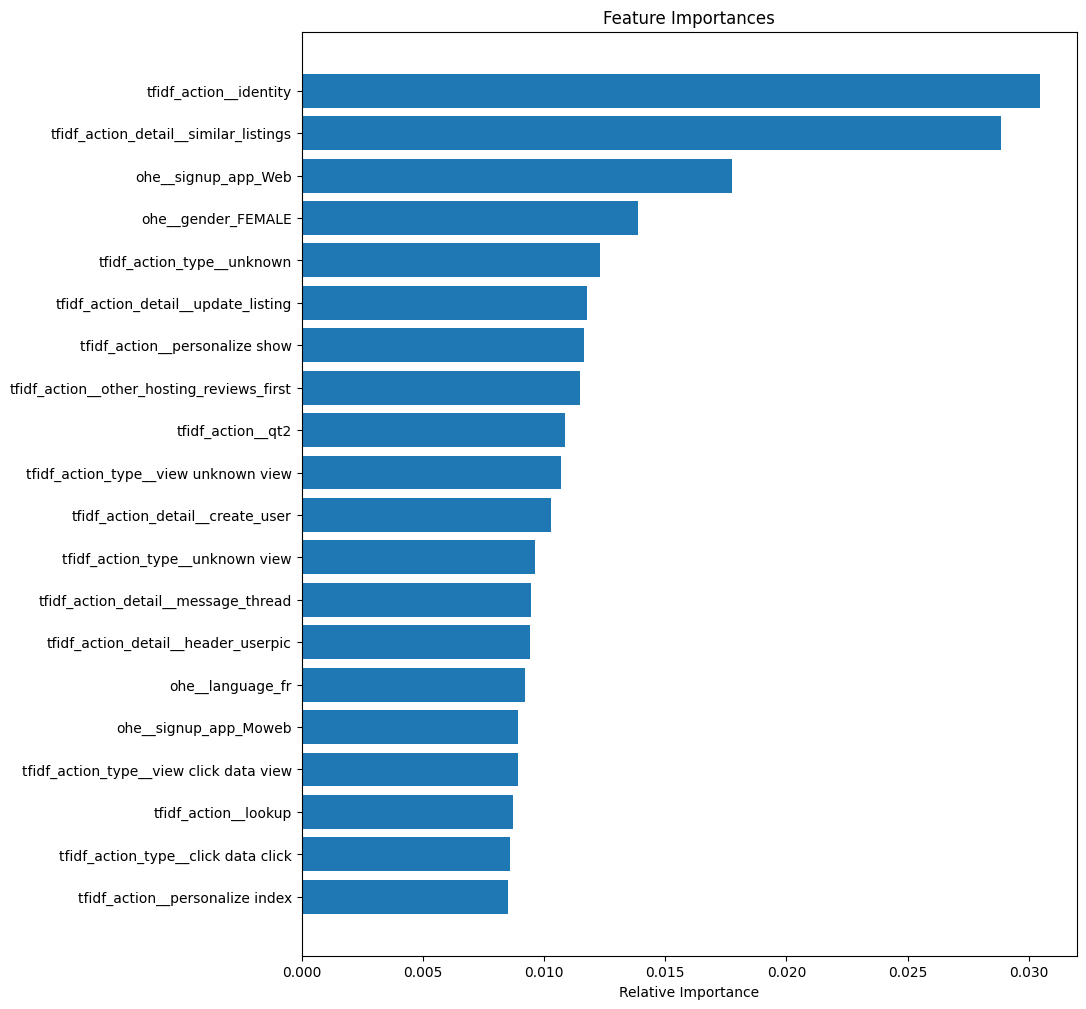

In [48]:
from utils import *
importances=xgb_model.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')

plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Retrain xgboost with top 80% important features

In [49]:
from scipy.sparse import hstack
top_80 = int(len(importances)*0.8)
indices = (np.argsort(importances))[::-1][:top_80]
cols = []
c=[]
features_new=[]
for i in indices:
    cols.append(X_train[:,i])
    c.append(X_test[:,i])
    features_new.append(feature_names[i])
X_train_new = hstack(cols)
X_test_new = hstack(c)

print("Final Data matrix")
print(X_train_new.shape)
print(X_test_new.shape)
print(Y_train.shape)
print(len(features_new))

Final Data matrix
(24457, 344)
(4317, 344)
(24457,)
344


In [52]:
xgb_model.fit(X_train_new,Y_train)
ndcg_scorer(xgb_model,X_test_new,Y_test)

0.8282682737615595

In [53]:
roc_auc_ovr_scorer(xgb_model,X_test_new,Y_test)

0.6151993256755584

The retrained xgboost model with top 80% important feature maintains a similar performance on the test set.

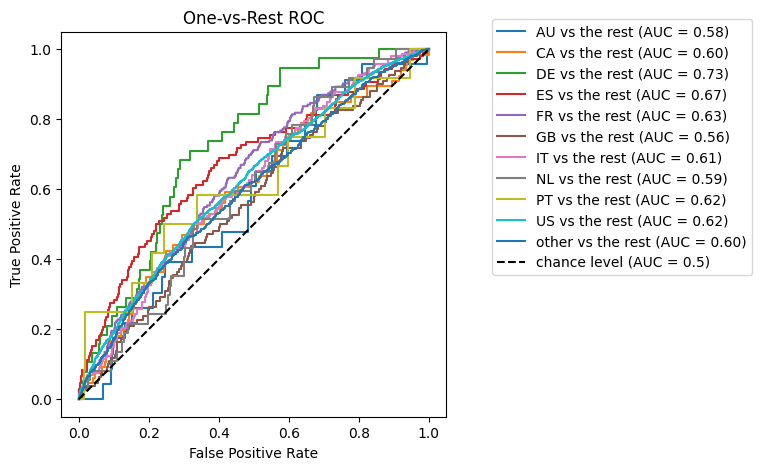

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import average_precision_score

y_score=xgb_model.predict_proba(X_test_new)

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape  

fig, ax = plt.subplots(figsize=(5,5))
for class_of_interest in list(label_dict.keys()):
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{label_dict[class_of_interest]} vs the rest",
        ax=ax
    )


plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

Looking at the ROC for the retrained xgboost model above, AUC for the classification of DE versus the rest is the highest with a value of 0.73 but quite low for the rest of classes. This indicate the model is able to do classification of DE to some extend but overall this model is not a great classifier.

# Model compile for deployment

Compile gradient boosting model into PyTorch tensors

In [64]:
from hummingbird.ml import convert, load
model = convert(xgb_model, 'pytorch')
model.save('hb_model')
# # Load the model back
# model = load('hb_model')

# Limitations & Furture work
This is the first attempt to solve the problem. A few limitations and potential solutions are discussed below. 
1. Underfitting issues are seen for the most of the miniority classes. Data imbalance could be one of the reasons. I have tried downsampling to mitigate this issue mainly due to limited computation resource but the performance was dropped. Other techniques like oversampling and weighted loss could be tried in the furture.
2. Models explored here are most traditional ML models. Deep learning models maybe worth investigating as there are many structures and optimization techniques were developed to deal with large imbalance dataset.
3. Voting is the model ensemble method implemented here but the improvement in performance is very limited. Other techniques like stacking is suggested to try out.
4. Random search is not the most efficient way to do hyperparameter tunig. Guassian process optimization could be a better progress to use.
5. More data on the destination country and booking details could also be useful.

# Appedix 

### Downsampling

minority_class:  26532
majority_class:  62376
degree of imbalance:  0.2984208395195033


<AxesSubplot: >

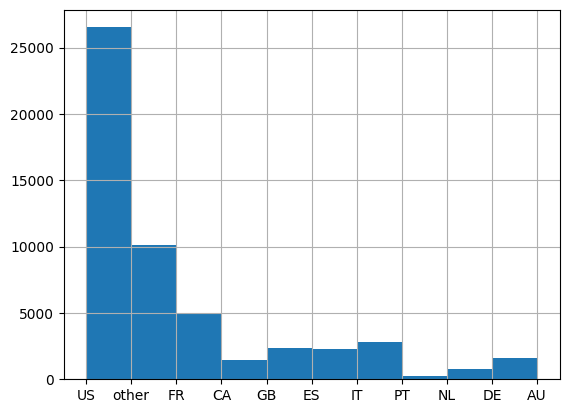

In [127]:
# majority_class = df_users[df_users.country_destination=='US']
# minority_class = df_users[~df_users.country_destination.isin(['US','NDF'])]
# print('minority_class: ', len(minority_class))
# print('majority_class: ', len(majority_class))
# print('degree of imbalance: ', len(minority_class)/(len(majority_class)+len(minority_class)))
# majority_downsampled = resample(majority_class, 
#                                 replace=False, 
#                                 n_samples=len(minority_class), 
#                                 random_state=0)
# downsampled_data = pd.concat([majority_downsampled, minority_class])
# downsampled_data.country_destination.hist()